# Bootes III Part 1

**The tasks completed in this notebook**

1. Identify BooIII spectroscopic member stars from S5 data
    - Take region near BooIII (radius 3 degrees)
    - Filter out poor measurement stars
    - RV cut from the RV histogram
    - PM box cut from the PM space
    - Crossmatch with RRL catalogue to find RRL stars
    - Plot them in 4 parameter spaces: (RA, Dec), PM, CMD, RV vs. [Fe/H]
    - Take only the stars within 5 half-light radius
    
    
2. Find kinematics and metallicity information of BooIII from the members
    - Compute systemic RV and the velocity dispersion using the stars not identified in the Gaia DR3 RRL catalogue
    - Compute mean PM, [Fe/H] and [Fe/H] dispersion using all stars


3. Use these systemic information to identify possible left out members.
    - Consider uncertainties of the data points (rather than an ordinary box cut without error bars)
   
   
The commented cells don't need to run to produce the results. But they can be uncommented to show what happens during the intermediate steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import table
from astropy.io import ascii

# Helper functions
from plot_functions import *
from analysis_functions_v2 import *

params['xtick.labelsize'] = 10
params['ytick.labelsize'] = 10
# params imported from plot_functions
plt.rcParams.update(params)

## Setting constants, loading files and S5 and Gaia DR3 RR Lyrae data

In [2]:
# Label shortcuts
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

# Known physical properties for analysis
# Source: Carlin 2018, https://iopscience.iop.org/article/10.3847/1538-4357/aad8c1#apjaad8c1t3
RA_BOO3, DEC_BOO3 = 209.3, 26.8 # deg
dm_boo3 = distance_to_dm(46.5 * 1000)

# Isochrone 
dartmouth_isochrone = ascii.read('boo3_iso.iso', header_start=8)
parsec_isochrone = ascii.read('parsec_isochrone.txt', header_start=13)

# M92 ridgeline for the BHB part of the isochrone, to be paired with the dartmouth isochrone
# Note: this is gr color and g mag (not g and r mags).
gr_iso_BHB, g_iso_BHB = get_BHB_iso_color_n_mag()

# Styx stream track (Grillmair 2009)
styx_trace = ascii.read('styx.trace')

# S5
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5_full = table.Table(hdu_list[1].data)

table_S5_full['decam_g0'], table_S5_full['decam_r0'], table_S5_full['decam_i0'], table_S5_full['decam_z0'] = deredden_mag_S5(table_S5_full)

# Gaia RRL
with fits.open('gaia_rrl_dr3_all.fits') as hdu_list:
    _table_rrl1 = table.Table(hdu_list[1].data)

with fits.open('GaiaDR3_RRLs_withMu_Lite.fits') as hdu_list: # this one has the EBV_SFD
    _table_rrl2 = table.Table(hdu_list[1].data)

table_rrl = table.join(_table_rrl1, _table_rrl2['source_id', 'EBV_SFD'], keys=['source_id'])

## Member selection

In [3]:
table_S5_cut = angular_radius_cut(table_S5_full, [RA_BOO3, DEC_BOO3], 3)

_quality_criteria = (table_S5_cut['best_sn_1700d'] > 2) & \
                    (table_S5_cut['vel_calib_std'] < 10) & \
                    (table_S5_cut['good_star_pb'] > 0.5)

table_S5_good = table_S5_cut[_quality_criteria]

In the cell below, the two selection criteria were manually determined by examining the plots\
Here we just put down the final results

The plot shows which part of the RV distribution is selected. \
The green doesn't fill to the top because there is also a PM box cut \
done on the PM distribution (to remove visibility obvious PM outliers).

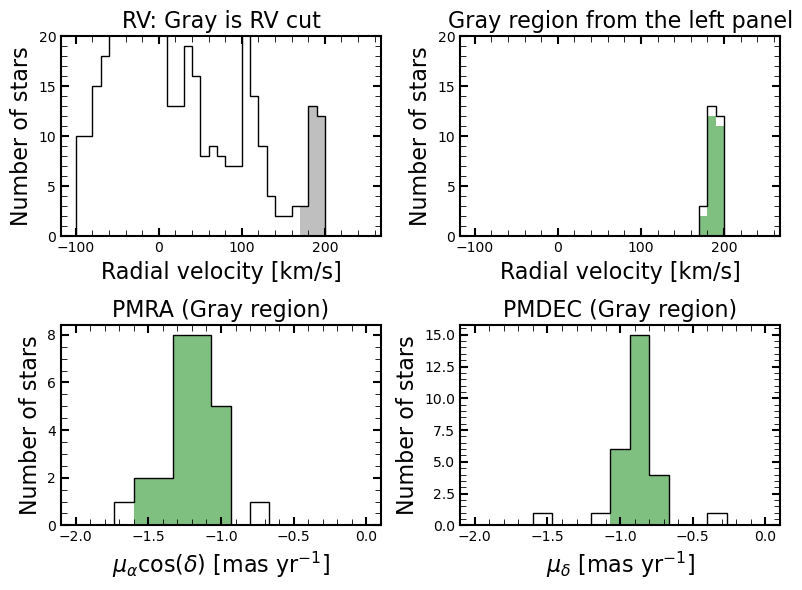

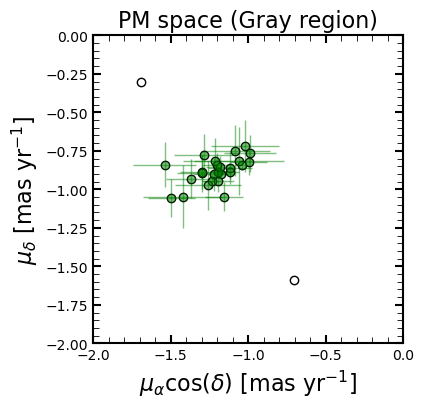

In [4]:
# These cut ranges are selected by eye
sel_rv_peak = (170 < table_S5_good['vel_calib']) & (table_S5_good['vel_calib'] < 220)  #150 240
sel_pm = (-2 < table_S5_good[sel_rv_peak]['pmra']) & (table_S5_good[sel_rv_peak]['pmra'] < -0.5) & \
         (-1.2 < table_S5_good[sel_rv_peak]['pmdec']) & (table_S5_good[sel_rv_peak]['pmdec'] < -0.6) #alt: -1.6 to -0.2

boo3_estimate = table_S5_good[sel_rv_peak][sel_pm]

plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plt.hist(table_S5_good['vel_calib'], bins=35, range=[-100, 250], histtype='step', ec='k')
plt.hist(table_S5_good[sel_rv_peak]['vel_calib'], bins=35, range=[-100, 250], fc='gray', alpha=0.5)
plot_labels('Radial velocity [km/s]', 'Number of stars', 'RV: Gray is RV cut')
plt.ylim(0, 20)

plt.subplot(2, 2, 2)
plt.hist(table_S5_good[sel_rv_peak]['vel_calib'], bins=35, range=[-100, 250], histtype='step', ec='k')
plt.hist(table_S5_good[sel_rv_peak][sel_pm]['vel_calib'], bins=35, range=[-100, 250], fc='g', alpha=0.5)
plot_labels('Radial velocity [km/s]', 'Number of stars', 'Gray region from the left panel')
plt.ylim(0, 20)

_pm_range = [-2, 0]

plt.subplot(2, 2, 3)
plt.hist(table_S5_good[sel_rv_peak]['pmra'], bins=15, range=_pm_range, histtype='step', ec='k')
plt.hist(table_S5_good[sel_rv_peak][sel_pm]['pmra'], bins=15, range=_pm_range, fc='g', alpha=0.5)
plot_labels(pmra_label, 'Number of stars', 'PMRA (Gray region)')

plt.subplot(2, 2, 4)
plt.hist(table_S5_good[sel_rv_peak]['pmdec'], bins=15, range=_pm_range, histtype='step', ec='k')
plt.hist(table_S5_good[sel_rv_peak][sel_pm]['pmdec'], bins=15, range=_pm_range, fc='g', alpha=0.5)
plot_labels(pmdec_label, 'Number of stars', 'PMDEC (Gray region)')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
plot_pm_ax(ax, table_S5_good[sel_rv_peak], '', fmt='o', c='none', mec='k', capsize=0, lw=0)
plot_pm_ax(ax, table_S5_good[sel_rv_peak][sel_pm], '', fmt='o', c='g', mec='none', alpha=0.5, capsize=0, lw=1)
ax_labels(ax, pmra_label, pmdec_label, 'PM space (Gray region)')
ax.set_xlim(*_pm_range)
ax.set_ylim(*_pm_range)
plt.show()

## Find RR Lyraes by crossmatching

In [5]:
rrl_matched_to_base, sep2d = crossmatch(boo3_estimate, table_rrl, get_sep2d=True)
boo3_main_rrl = boo3_estimate[sep2d < 1*units.arcsec]

boo3_likely_members = table.setdiff(boo3_estimate, boo3_main_rrl, keys=['source_id'])

print("Numbers:")
print("All from RV + PM cut:\t", len(boo3_estimate))
print("Identified RR Lyraes:\t", len(boo3_main_rrl))
print("Other likely members:\t", len(boo3_likely_members))

Numbers:
All from RV + PM cut:	 25
Identified RR Lyraes:	 3
Other likely members:	 22


## Remove stars too far from 3 * half-light radius

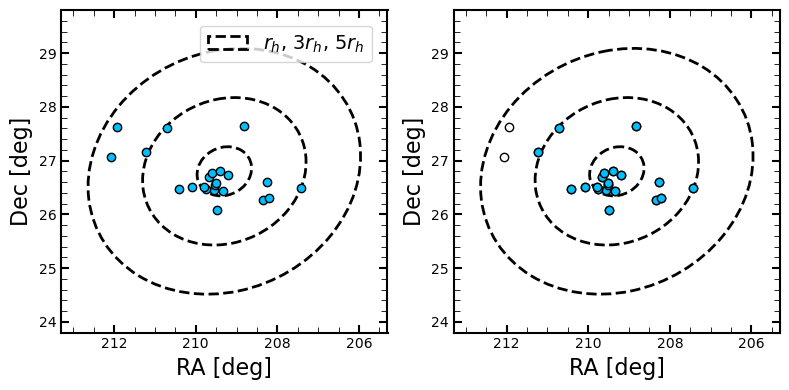

In [6]:
boo3_main_members = boo3_likely_members[boo3_likely_members['ra'] < 211.5]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_rh(ax[0])
ax[0].plot(boo3_likely_members['ra'], boo3_likely_members['dec'], 'o', c='deepskyblue', mec='k')
ax[0].set_xlabel('RA [deg]')
ax[0].set_ylabel('Dec [deg]')
ax[0].set_xlim(RA_BOO3-4, RA_BOO3+4)
ax[0].set_ylim(DEC_BOO3-3, DEC_BOO3+3)
ax[0].invert_xaxis()
ax[0].legend()

plot_rh(ax[1])
ax[1].plot(boo3_likely_members['ra'], boo3_likely_members['dec'], 'o', c='none', mec='k')
ax[1].plot(boo3_main_members['ra'], boo3_main_members['dec'], 'o', c='deepskyblue', mec='k')
ax[1].set_xlabel('RA [deg]')
ax[1].set_ylabel('Dec [deg]')
ax[1].set_xlim(RA_BOO3-4, RA_BOO3+4)
ax[1].set_ylim(DEC_BOO3-3, DEC_BOO3+3)
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

In [7]:
boo3_toofar = table.setdiff(boo3_likely_members, boo3_main_members, keys=['source_id'])

In [8]:
print("Numbers:")
print("All from RV + PM cut:\t", len(boo3_estimate))
print("Chosen RR Lyraes:\t", len(boo3_main_rrl))
print("Chosen core members:\t", len(boo3_main_members))
print("Ruled out from core:\t", len(boo3_likely_members) - len(boo3_main_members))

Numbers:
All from RV + PM cut:	 25
Chosen RR Lyraes:	 3
Chosen core members:	 20
Ruled out from core:	 2


## Fit parameters 
**Don't run this, as the final fit values will vary a little in the decimals. The samples (output from the vdisp.mcmc) are stored as .dat files, you can load them in an make the same plots.**

Mean RV: 191.30819108650803 -0.8164398287106849 0.6853519437246121
RV dispersion: 1.8766984817264767 -0.714606588049685 0.8651969471836063
95% dispersion: 3.463939909133279


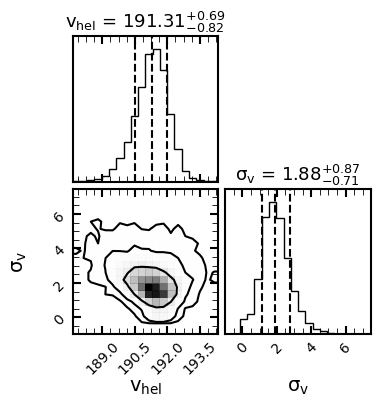

100%|██████████| 1500/1500 [00:01<00:00, 949.27it/s]


PMRA -- -1.1562409259882522 0.01733791438375465 0.01734022107173372
PMDEC-- -0.8795042533303533 0.013391504385886988 0.013598049104507792


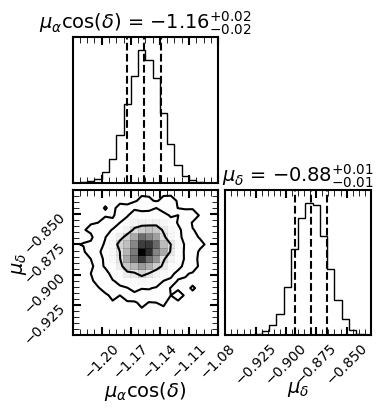

Mean [Fe/H]: -2.308183975555019 -0.10433920967626475 0.0999235470032076
[Fe/H] dispersion: 0.40407519657164964 -0.06956937632341448 0.08778787304312491
95% dispersion: 0.5599068311412974


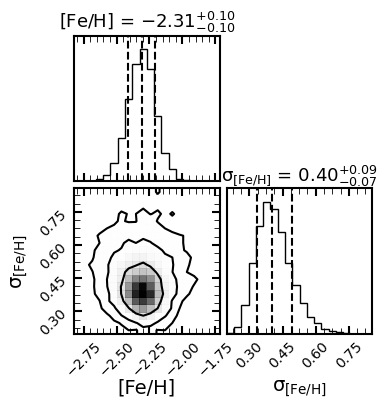

In [9]:
import vdisp
import corner
import mcmc_wrapper

# VELOCITY
samples = vdisp.mcmc(boo3_main_members['vel_calib'], boo3_main_members['vel_calib_std'], nsteps=1000)
ascii.write(samples, 'boo3_velocity_fit_sample.dat', overwrite=True)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

print('Mean RV:', np.median(mu), np.percentile(mu, 16) - np.median(mu), np.percentile(mu, 84) - np.median(mu))
print('RV dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma), np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

rv_mean = np.median(mu)
rv_mean_err = (np.percentile(mu, 84) - np.percentile(mu, 16)) / 2  # average of the upper and lower errors
rv_disp = np.median(sigma)
rv_disp_err = (np.percentile(sigma, 84) - np.percentile(sigma, 16)) / 2

figure = corner.corner(samples,
                       labels=["$\mathrm{v_{hel}}$", "$\mathrm{\sigma_{v}}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize=14),
                       range=[[np.min(mu), np.max(mu)], [np.min(sigma) - 1, np.max(sigma)]],
                       ls='--', lw=1.5, c='gray', alpha=0)
figure.set_size_inches(4, 4)
plt.savefig('rv_fit.png', dpi=300)
plt.show()

# PROPER MOTION
all_pmra = np.concatenate((boo3_main_members['pmra'], boo3_main_rrl['pmra']))
all_pmra_err = np.concatenate((boo3_main_members['pmra_error'], boo3_main_rrl['pmra_error']))
all_pmdec = np.concatenate((boo3_main_members['pmdec'], boo3_main_rrl['pmdec']))
all_pmdec_err = np.concatenate((boo3_main_members['pmdec_error'], boo3_main_rrl['pmdec_error']))
all_pm_corr = np.concatenate((boo3_main_members['pmra_pmdec_corr'], boo3_main_rrl['pmra_pmdec_corr']))

data_in = [all_pmra, all_pmdec, all_pmra_err, all_pmdec_err, all_pm_corr]

data_out = mcmc_wrapper.mcmc_pm(data_in, nsteps=1000)

_packed_pmra, _packed_pmdec, samples = mcmc_wrapper.plot_pm(data_out, plot_range=[[-1.23, -1.08], [-0.95, -0.83]])
ascii.write(samples, 'boo3_pm_fit_sample.dat', overwrite=True)

pmra = _packed_pmra[0]
pmra_err = (_packed_pmra[2] - _packed_pmra[1]) / 2
pmdec = _packed_pmdec[0]
pmdec_err = (_packed_pmdec[2] - _packed_pmdec[1]) / 2

# METALLICITY
all_feh = np.concatenate((boo3_main_members['feh50'], boo3_main_rrl['feh50']))
all_feh_err = np.concatenate((boo3_main_members['feh_calib_std'], boo3_main_rrl['feh_calib_std']))

samples = vdisp.mcmc(all_feh, all_feh_err, nsteps=1000)
ascii.write(samples, 'boo3_feh_fit_sample.dat', overwrite=True)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

# Median, and percentiles
print('Mean [Fe/H]:', np.median(mu), np.percentile(mu, 16) - np.median(mu), np.percentile(mu, 84) - np.median(mu))
print('[Fe/H] dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma), np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

feh_mean = np.median(mu)
feh_mean_err = (np.percentile(mu, 84) - np.percentile(mu, 16)) / 2
feh_disp = np.median(sigma)
feh_disp_err = (np.percentile(sigma, 84) - np.percentile(sigma, 16)) / 2

figure = corner.corner(samples,
                       labels=["[Fe/H]", "$\mathrm{\sigma_{[Fe/H]}}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize=14),
                       range=[[np.min(mu), np.max(mu)], [np.min(sigma), np.max(sigma)]],
                       ls='--', lw=1.5, c='gray', alpha=0)
figure.set_size_inches(4, 4)
plt.savefig('feh_fit.png', dpi=300)
plt.show()

In [10]:
print("Best Fit:")
print(f"Systemic Velocity:\t{rv_mean:.2f} +/- {rv_mean_err:.2f}")
print(f"Velocity Dispersion:\t{rv_disp:.2f} +/- {rv_disp_err:.2f}")
print("Systemic Proper Motion:")
print(f"\t\tpmra:\t{pmra:.2f} +/- {pmra_err:.2f}")
print(f"\t\tpmdec:\t{pmdec:.2f} +/- {pmdec_err:.2f}")
print(f"Systemic Metallicity:\t{feh_mean:.2f} +/- {feh_mean_err:.2f}")
print(f"Metallicity Dispersion:\t{feh_disp:.2f} +/- {feh_disp_err:.2f}")

Best Fit:
Systemic Velocity:	191.31 +/- 0.75
Velocity Dispersion:	1.88 +/- 0.79
Systemic Proper Motion:
		pmra:	-1.16 +/- 0.02
		pmdec:	-0.88 +/- 0.01
Systemic Metallicity:	-2.31 +/- 0.10
Metallicity Dispersion:	0.40 +/- 0.08


In [11]:
add_dm_to_RRLs(rrl_matched_to_base, feh_mean)
boo3_main_rrl = table.hstack([boo3_main_rrl, rrl_matched_to_base['dm']])

In [12]:
ascii.write(boo3_main_members, 'boo3_main_members.dat', overwrite=True)
ascii.write(boo3_main_rrl, 'boo3_main_rrl.dat', overwrite=True)

### Key Figure

In [13]:
boo3_main_members = ascii.read('boo3_main_members.dat')
boo3_main_rrl = ascii.read('boo3_main_rrl.dat')

# The rest of this cell is just processing a table
carlin18_members = ascii.read('carlin2018_members.txt', header_start=2, data_start=4, data_end=-5, delimiter='\t')
carlin18_members = carlin18_members[carlin18_members['Member?'] == 'Y']

carlin18_members.rename_column('alpha', 'ra')
carlin18_members.rename_column('delta', 'dec')
carlin18_members.rename_column('mu_alpha*', 'pmra')
carlin18_members.rename_column('mu_delta', 'pmdec')
carlin18_members.rename_column('v_helio', 'rv')

def separate_errors(table, column_name):
    """An exclusive helper function for a specific table.
    
    One-time use only.
    """
    nominals = []
    errors = []

    for rv in carlin18_members[column_name]:
        nominal, error = rv.split(' +or- ')
        nominals.append(float(nominal))
        errors.append(float(error))

    table[column_name] = nominals
    table[column_name + '_error'] = errors

separate_errors(carlin18_members, 'rv')
separate_errors(carlin18_members, 'pmra')
separate_errors(carlin18_members, 'pmdec')

fehs = []

for feh in carlin18_members['[Fe/H]^a']:
    if feh == 'cdots':
        fehs.append(np.nan)
    else:
        fehs.append(float(feh))

carlin18_members['feh'] = fehs

In [14]:
pm_cut_box = shapelyPolygon([[-2, -1.4], [-2, -0.4], [-0.5, -0.4], [-0.5, -1.4]])

In [15]:
params['xtick.labelsize'] = 12
params['ytick.labelsize'] = 12
plt.rcParams.update(params)

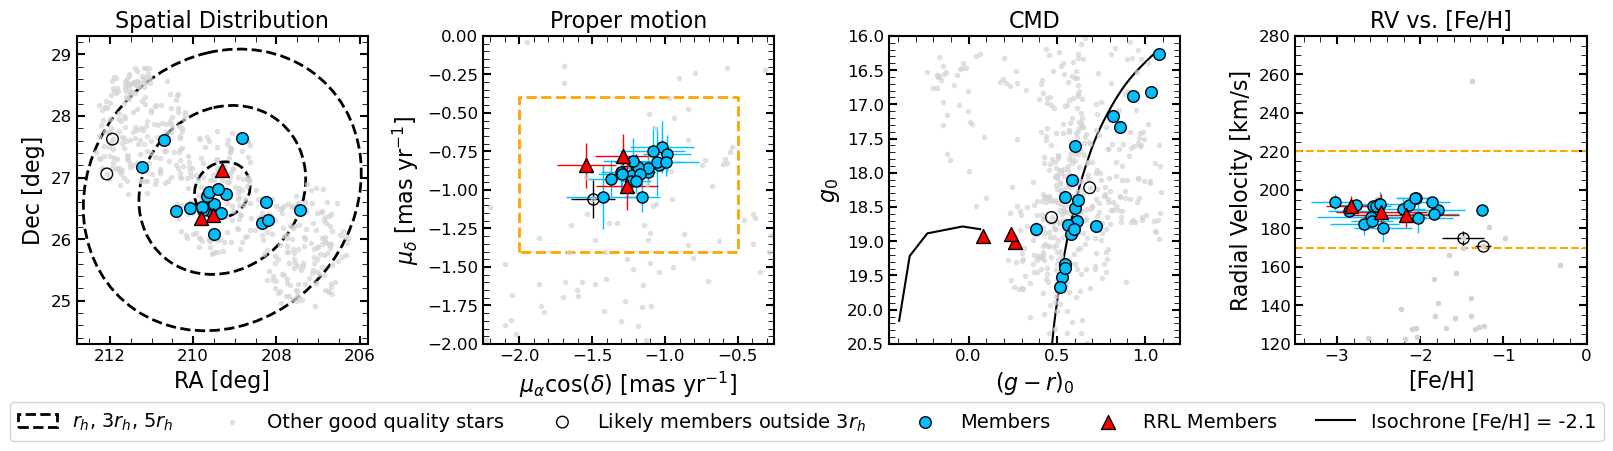

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4.2))

plot_rh(ax[0])
plot_onsky(fig, ax[0], table_S5_good, 'Other good quality stars', marker='.', c='lightgray', zorder=1, alpha=0.6)
#plot_onsky(fig, ax[0], carlin18_members, 'Carlin 2018', marker='D', s=80, c='none', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_toofar, r'Likely members outside $3r_h$', marker='o', s=70, c='none', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_members, 'Members', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'RRL Members', marker='^', s=100, c='red', ec='k', zorder=2)
ax_labels(ax[0], 'RA [deg]', 'Dec [deg]', 'Spatial Distribution')
ax[0].set_xlim(RA_BOO3-3.5, RA_BOO3+3.5)
ax[0].set_ylim(DEC_BOO3-2.5, DEC_BOO3+2.5)
ax[0].invert_xaxis()

plot_pm_ax(ax[1], table_S5_good, '', fmt='.', c='lightgray', capsize=0, lw=0, alpha=0.6)
#plot_pm_ax(ax[1], carlin18_members, '', fmt='D', ms=8, c='none', mec='k', capsize=0, ecolor='gray', lw=1)
plot_pm_ax(ax[1], boo3_toofar, '', fmt='o', ms=8, c='none', mec='k', ecolor='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_main_rrl, '', fmt='^', ms=10, c='red', mec='k', capsize=0, lw=1)
ax[1].plot(*pm_cut_box.exterior.xy, lw=2, ls='--', c='orange')
ax_labels(ax[1], pmra_label, pmdec_label, 'Proper motion')
ax[1].set_xlim(-2.25, -0.25)
ax[1].set_ylim(-2, 0)

plot_RGB_isochrone(ax[2], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], dm_boo3, 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[2], dm_boo3, c='k')
plot_cmd(fig, ax[2], table_S5_good['decam_g0'], table_S5_good['decam_r0'], '', marker='.', c='lightgray', alpha=0.6)
#plot_cmd(fig, ax[2], carlin18_members['g'], carlin18_members['r'], '', marker='D', s=70, c='none', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_toofar['decam_g0'], boo3_toofar['decam_r0'], '', marker='o', s=70, c='none', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_main_members['decam_g0'], boo3_main_members['decam_r0'], '', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_main_rrl['decam_g0'], boo3_main_rrl['decam_r0'], '', marker='^', s=100, c='red', ec='k', zorder=2)
ax_labels(ax[2], r'$(g-r)_0$', r'$g_0$', 'CMD')
ax[2].set_xlim(-0.45, 1.2)
ax[2].set_ylim(16, 20.5)
ax[2].invert_yaxis()

plot_rv_metallicity_ax(ax[3], table_S5_good, '', fmt='.', c='lightgray', lw=0)
#ax[3].errorbar(carlin18_members['feh'], carlin18_members['rv'], yerr=carlin18_members['rv_error'], fmt='D', ms=8, c='none', mec='k', ecolor='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_toofar, '', fmt='o', ms=8, c='none', mec='k', ecolor='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_main_rrl, '', fmt='^', ms=10, c='red', mec='k', lw=1)
ax[3].axhline(220, ls='--', c='orange') # 240
ax[3].axhline(170, ls='--', c='orange') # 150
ax_labels(ax[3], '[Fe/H]', 'Radial Velocity [km/s]', 'RV vs. [Fe/H]')
ax[3].set_ylim(120, 280)
ax[3].set_xlim(-3.5, 0)

lgd = fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=7, prop={'size': 14})
plt.tight_layout()
fig.savefig('main_members.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

In [17]:
print("Number of BooIII stars:", len(boo3_main_members), "+", len(boo3_main_rrl))

Number of BooIII stars: 20 + 3
